# Setup

In [1]:
include(joinpath("..","src","setup.jl"))
datadir = joinpath("..","data","count_lengths","run_2018-11-26")

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/davidlittle/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


"../data/count_lengths/run_2018-11-26"

# TODO: 

- work out the parameters to vary
- run a simulation

## New plans

Once that's done I can work on the New Stimuli notebook and check out context. At that point I can see if the same problem with 12st persists, and really get in to the context stimuli.

In [56]:
params = load_params(joinpath(datadir,"params.jld2"))
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")
settings = TOML.parsefile(settings)

Dict{AbstractString,Any} with 9 entries:
  "percept_lengths" => Dict{AbstractString,Any}("threshold"=>0.2,"min_length_ms…
  "freqs"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "mask"            => Dict{AbstractString,Any}("window_ms"=>500,"delta_ms"=>25…
  "rates"           => Dict{AbstractString,Any}("rates_Hz"=>[2, 4, 8, 16, 32],"…
  "scales"          => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "stimulus"        => Dict{AbstractString,Any}("repeats"=>100,"ramp_len_ms"=>1…
  "track"           => Dict{AbstractString,Any}("bistable"=>Dict{AbstractString…
  "nmf"             => Dict{AbstractString,Any}("skipframes"=>0,"tol"=>0.001,"w…
  "bandwidth_ratio" => Dict{AbstractString,Any}("window_ms"=>800,"full_band_rat…

In [57]:
results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[57]:9
└ @ Core In[57]:9


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,23.3,1,2018-11-26T17:38:30.128,1
2,23.3,1,2018-11-26T17:40:27.495,1
3,23.3,1,2018-11-26T17:40:30.437,1
4,23.3,1,2018-11-26T17:40:33.359,1
5,23.3,1,2018-11-26T17:40:36.249,1
6,23.3,1,2018-11-26T17:40:39.153,1


In [58]:
settings["track"]["analyze"]["source_prior_sd_bias"] = [4000,0,0]
settings["track"]["analyze"]["source_prior_strength_bias"] = [4000,0]
settings["stimulus"]["repeats"] = 30

30

# High rate build-up

In [74]:
settings["rates"]["rates_Hz"] = exp.(range(log(32),log(64),length=5))

5-element Array{Float64,1}:
 32.0             
 38.05462768008707
 45.25483399593902
 53.81737057623771
 63.99999999999998

In [75]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])

,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ,pindex
,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Int64,Float64,Quantity…,Quantity…,Float64,Int64
1,5.6,0.0,5.0,5.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.0,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.2,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,6,3.0,350 ms,500 ms,15.0,712


In [71]:
result = []
@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup_large = vcat(result...);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:34


In [106]:
sdf = buildup_mean(buildup_large,delta=0.24,length=14);

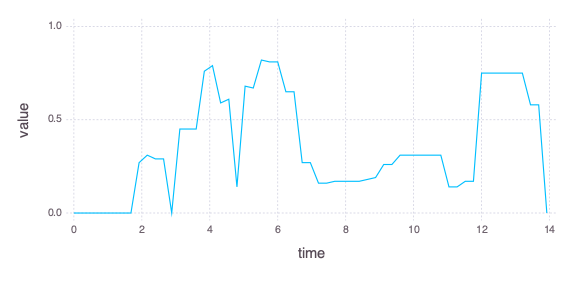

false

In [107]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=14)))

In [108]:
result = bistable_model(p,settings,intermediate_results=true);

┌ Info: 15.97% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/OvbvN/src/nmf.jl:45


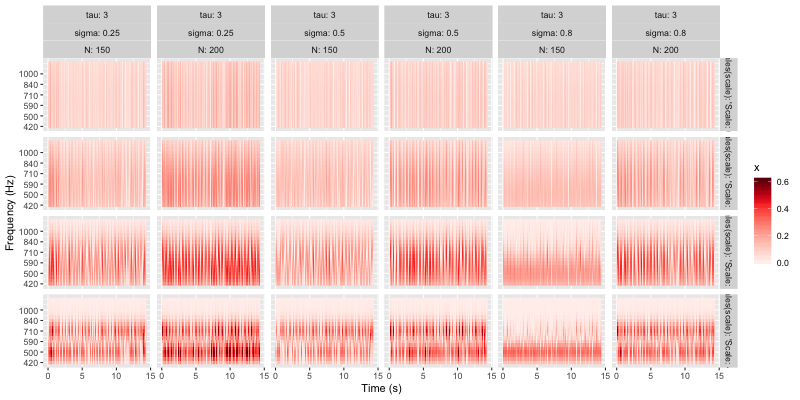

RObject{VecSxp}


In [95]:
rplot(result.sources.tracks)

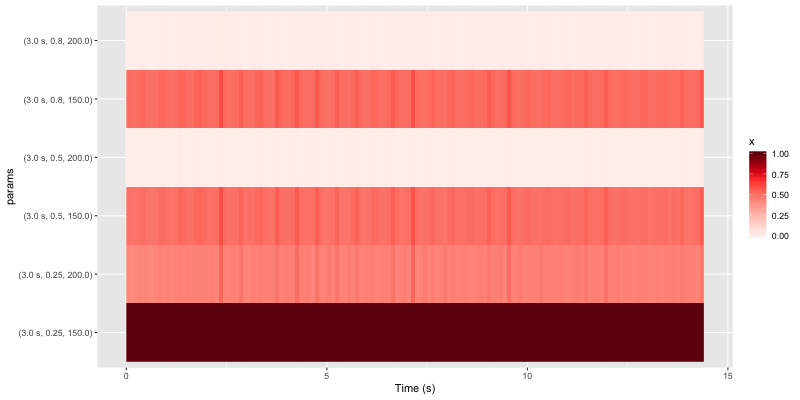

RObject{VecSxp}


In [96]:
rplot(result.sources.inweights)

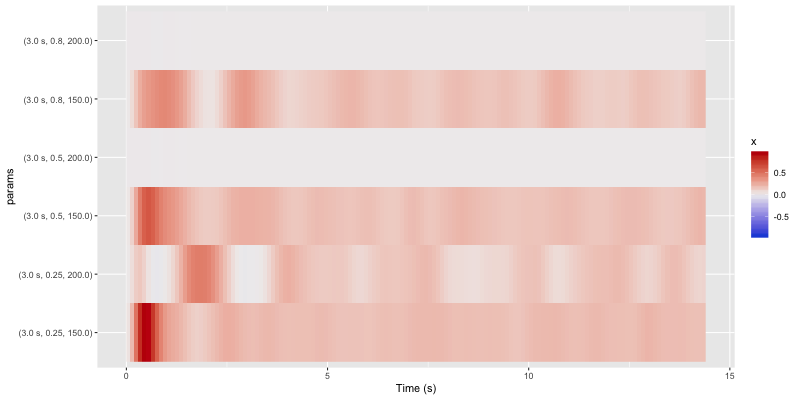

RObject{VecSxp}


In [97]:
rplot(result.sources.outweights)

In [98]:
result.percepts.counts

([2.1, 0.7, 2.2, 1.6, 4.2, 0.6, 2.3], Bool[false, true, false, true, false, true, false])

# Low-rate build-up

In [133]:
settings["rates"]["rates_Hz"] = exp.(range(log(1),log(4),length=5))

5-element Array{Float64,1}:
 1.0              
 1.414213562373095
 2.0              
 2.82842712474619 
 4.0              

In [134]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])

,f_W_m_σ,f_c_m,t_c_a,t_c_m,f,t_W_m_c,t_c_x,f_c_x,t_W_m_σ_t,s_τ_σ,f_c_a,f_c_σ,s_c_m,f_τ_a,s_c_σ,Δt,s_τ_m,s_c_x,t_W_m_σ_ϕ,t_τ_a,s_c_a,t_τ_m,t_c_σ,t_τ_x,s_W_m_c,s_τ_a,f_W_m_c,t_τ_σ,f_τ_σ,f_τ_x,Δf,t_W_m_σ_N,f_τ_m,s_τ_x,s_W_m_σ,pindex
,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Quantity…,Float64,Float64,Float64,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Int64,Float64,Quantity…,Quantity…,Float64,Int64
1,5.6,0.0,5.0,5.0,500 Hz,6.0,3.0,3.0,7.0,500 ms,0.0,0.0,0.0,3 s,0.0,120 ms,350 ms,3.0,7.0,3 s,0.0,350 ms,0.2,500 ms,6.0,3 s,6.0,500 ms,500 ms,500 ms,6,3.0,350 ms,500 ms,15.0,712


In [111]:
result = []
@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup_small = vcat(result...);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


In [131]:
sdf = buildup_mean(buildup_small,delta=0.24,length=14);

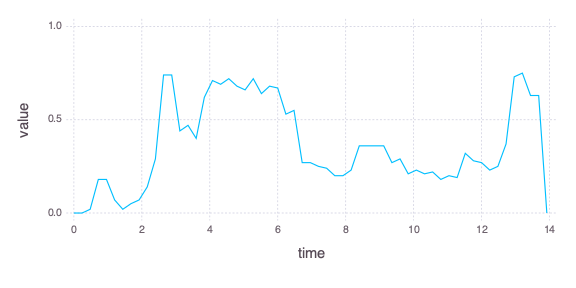

false

In [132]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=14)))

In [135]:
result = bistable_model(p,settings,intermediate_results=true);

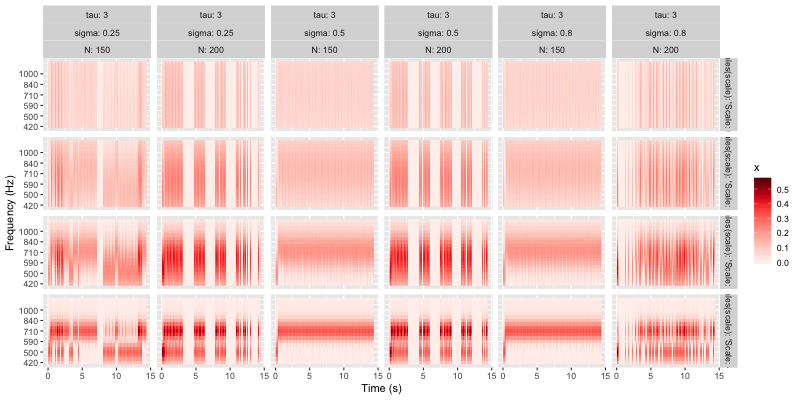

RObject{VecSxp}


In [136]:
rplot(result.sources.tracks)

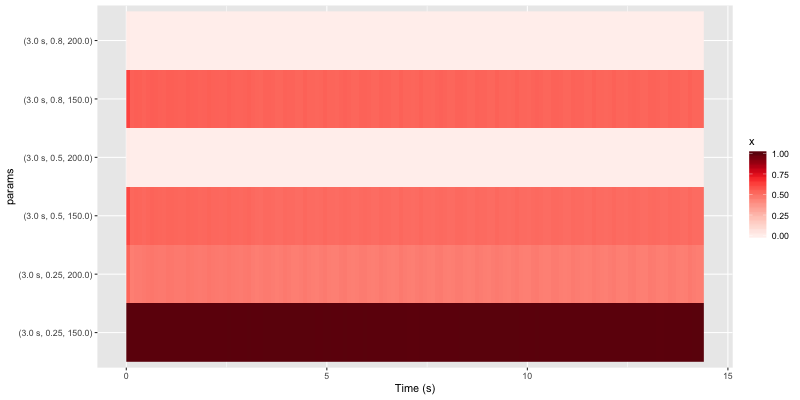

RObject{VecSxp}


In [137]:
rplot(result.sources.inweights)

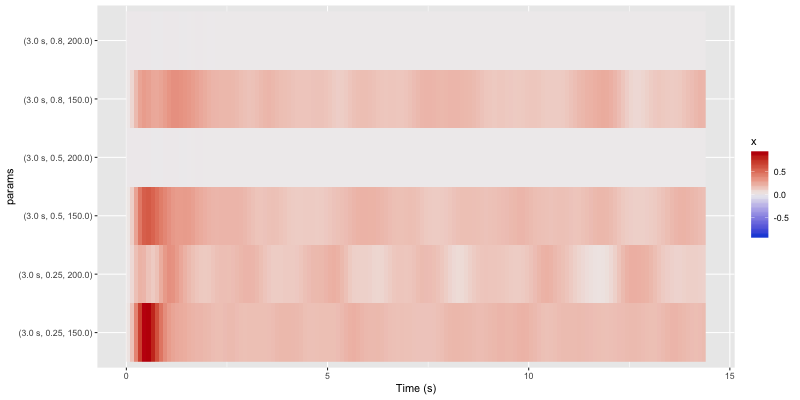

RObject{VecSxp}


In [138]:
rplot(result.sources.outweights)

In [139]:
result.percepts.counts

([0.6, 1.8, 1.1, 0.7, 1.0, 3.0, 2.5, 1.1, 1.9], Bool[false, true, false, true, false, true, false, true, false])

# Normal-rate buildup

In [121]:
settings["rates"]["rates_Hz"] = [2,4,8,16,32]

5-element Array{Int64,1}:
  2
  4
  8
 16
 32

In [122]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.2
p.s_c_σ = 1.2
p.f_c_σ = 1.2

1.2

In [128]:
result = []
@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup_standard = vcat(result...);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:56


In [129]:
sdf = buildup_mean(buildup_standard,delta=0.24,length=14);

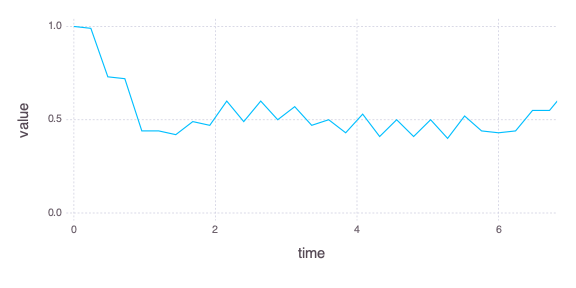

false

In [130]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=6.72)))

In [123]:
result = bistable_model(p,settings,intermediate_results=true);

┌ Info: 11.81% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/.julia/packages/AuditoryBistabilityLE/OvbvN/src/nmf.jl:45


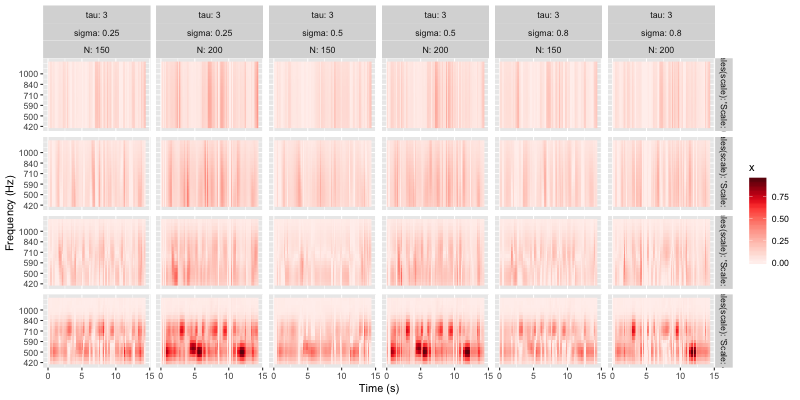

RObject{VecSxp}


In [124]:
rplot(result.sources.tracks)

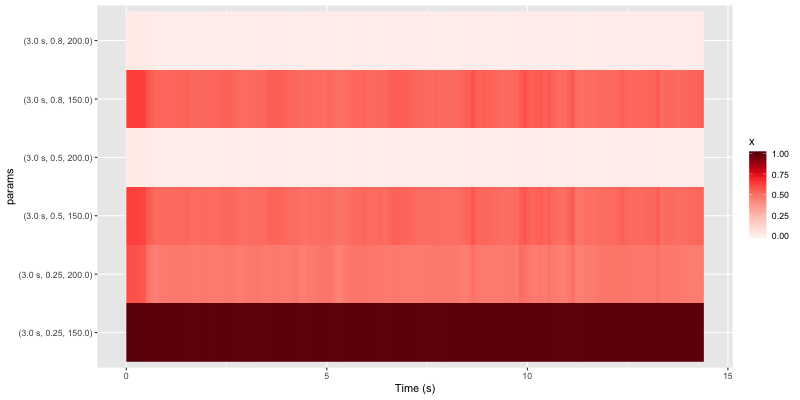

RObject{VecSxp}


In [125]:
rplot(result.sources.inweights)

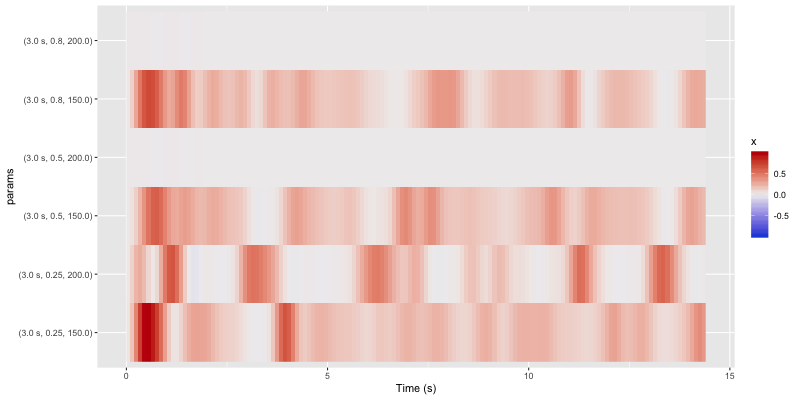

RObject{VecSxp}


In [126]:
rplot(result.sources.outweights)

In [127]:
result.percepts.counts

([0.8, 0.4, 0.6, 4.6, 1.2, 0.3, 0.6, 1.2, 0.3, 1.2, 0.7, 1.8], Bool[true, false, true, false, true, false, true, false, true, false, true, false])

In [ ]:
result = []
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])
p.t_c_σ = 1.2
p.s_c_σ = 1.2
p.f_c_σ = 1.2

@showprogress for i in 1:100
    with_logger(NullLogger()) do
        len,val = bistable_model(p,settings,intermediate_results=true).percepts.counts
        push!(result,DataFrame(length=len,response=val.+1,run=i))
    end
end
buildup = vcat(result...);

In [48]:
sdf = buildup_mean(buildup,delta=0.24,length=14);

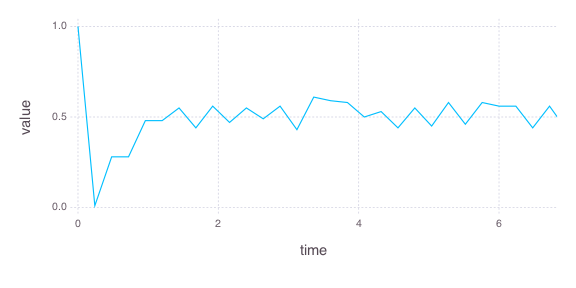

false

In [49]:
draw(PNG(6inch,3inch),plot(sdf,x=:time,y=:value,Geom.line,Coord.cartesian(ymax=1.0,xmax=6.72)))

In [15]:
hdf = CSV.read(joinpath("..","analysis","context","exp1A.csv"))
head(hdf)

,Column1,sid,sample,time,context_A,context_B,st,test_A,test_B,response,same_freq
,Int64⍰,String⍰,Int64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰
1,1,CK,1,0.24,1,1,0,300,424,0,FALSE
2,2,CK,2,0.48,1,1,0,300,424,0,FALSE
3,3,CK,3,0.72,1,1,0,300,424,0,FALSE
4,4,CK,4,0.96,1,1,0,300,424,0,FALSE
5,5,CK,5,1.2,1,1,0,300,424,0,FALSE
6,6,CK,6,1.44,1,1,0,300,424,0,FALSE


In [16]:
delta = diff(hdf.time[1:2])[1]

0.24

In [ ]:
okay, that seems to be a very sudden transition. Does this transition depend on the time constant?

In [ ]:
I coudl setup a very simple run to do this on the server, shouldn't take long

In [17]:
hdf_mean = @linq hdf |>
  where((:st .== 6) .& (:same_freq.=="TRUE")) |>
  by(:time,response = mean(:response))
head(hdf_mean)

,time,response
,Float64⍰,Float64
1,0.24,0.0
2,0.48,0.0
3,0.72,0.0
4,0.96,0.0
5,1.2,0.00925926
6,1.44,0.037037


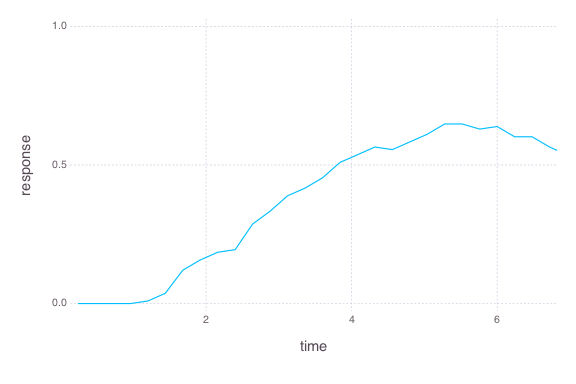

false

In [18]:
draw(PNG(6inch,4inch),plot(hdf_mean,x=:time,y=:response,Geom.line,Coord.cartesian(xmax=6.72,ymax=1.0)))

In [19]:
rms(sdf.value[0.0 .< sdf.time .< 6.72] .- hdf_mean.response[hdf_mean.time .< 6.72])

0.22114674596182657